In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip


# set to Arial
plt.rcParams['font.sans-serif'] = "Arial"
cmap5 = ['#355070', '#6D597A', '#B56576', '#E56B6F', '#EAAC8B']
cmap3 = ['#d62828', '#1d3557', '#f4a261', '#9cb29e']

%matplotlib inline

14
21
14
21


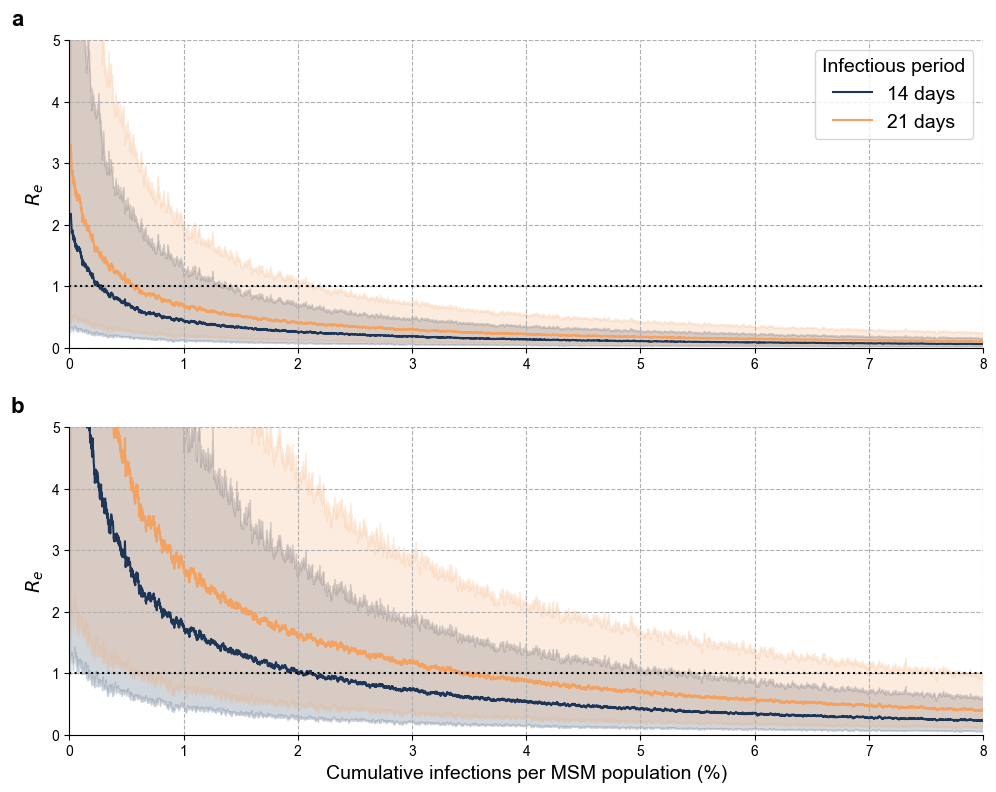

In [2]:
def plot_Re_all(df_paths, SARs=[0.1, 0.3, 0.5], inf_periods=[14, 21], colormap=None, ax=None, legend=True, xlabel=True, fontsize=14, xlim=[0,5]):
    linestyles = ['-', '--', ':']
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    if colormap is None:
        colormap = plt.cm.viridis
        for i, inf_period in enumerate(inf_periods):
            color = colormap(i/len(inf_periods))
            df = pd.read_csv(df_paths[i])

            for j, SAR in enumerate(SARs):
                linestyle = linestyles[j]
                plot_single_Re(df, SAR, color=color, linestyle=linestyle, label=f'Inf. period: {inf_period} days, SAR: {SAR}', ax=ax, fontsize=fontsize)

    else:
        for i, inf_period in enumerate(inf_periods):
            print(inf_period)
            color = colormap[i]
            df = pd.read_csv(df_paths[i])

            for j, SAR in enumerate(SARs):
                linestyle = linestyles[j]
                if len(SARs) == 1:
                    label = f'{inf_period} days'
                else:
                    label = f'Inf. period: {inf_period} days, SAR: {SAR}'
                plot_single_Re(df, SAR, color=color, linestyle=linestyle, label=label, ax=ax)

    if xlabel:
        ax.set_xlabel('Cumulative infections per MSM population (%)', fontsize=fontsize)
    ax.set_ylabel('$R_e$', fontsize=fontsize)

    ax.set_ylim([0,5])
    ax.set_xlim(xlim)

    ax.hlines(1, 0, 100000, color='k', linestyle=':')
    if legend:
        ax.legend(frameon=True, title='Infectious period', title_fontsize=fontsize, fontsize=fontsize, loc='upper right')

    # remove top and right spines
    sns.despine()
    ax.grid(which='major', axis='both', linestyle='--')


def plot_single_Re(df, SAR, ax, color='k', label=None, linestyle='-'):
    ax.plot(df['outbreaksize']/len(df)*100, df['0.5']*SAR, label=label, color=color, linestyle=linestyle)
    ax.fill_between(df['outbreaksize']/len(df)*100, df['0.025']*SAR, df['0.975']*SAR, alpha=0.2, color=color)


Re_14d_235k_path = '../simulations/output/R0sdeplete_235k.14d.csv'
Re_21d_235k_path = '../simulations/output/R0sdeplete_235k.21d.csv'

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_Re_all([Re_14d_235k_path, Re_21d_235k_path], SARs=[0.1], colormap=[cmap3[1], cmap3[2]], ax=axes[0], xlabel=False, legend=True, xlim=[0, 8])
plot_Re_all([Re_14d_235k_path, Re_21d_235k_path], SARs=[0.4], colormap=[cmap3[1], cmap3[2]], ax=axes[1], legend=False, xlim=[0, 8])
axes[0].text(-0.05, 1.1, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[1].text(-0.05, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
plt.tight_layout(h_pad=2)

In [3]:
def high_conn_perc_remaining(deg_path, degmat_path, high_conn_thresh):
    deg = pd.read_csv(deg_path)
    high_conn_lim = np.percentile(deg['deg_column'], 100-high_conn_thresh)
    high_conn_total = sum(deg['deg_column'] > high_conn_lim)

    high_conn_list = np.array([sum(deg['deg_column'] > high_conn_lim)] * 1000)
    high_conn_perc_remaining = []

    for l in open(degmat_path):
        if 'x' in l:
            continue
        l = [float(x) for x in l.strip().split(',')]
        for index, d in enumerate(l):
            if d > high_conn_lim:
                high_conn_list[index] -= 1
        
        perc_remaining = high_conn_list / high_conn_total
        high_conn_perc_remaining.append([np.percentile(perc_remaining, 2.5), np.percentile(perc_remaining, 25), np.percentile(perc_remaining, 50), np.percentile(perc_remaining, 75), np.percentile(perc_remaining, 97.5)])

    return high_conn_perc_remaining


def high_conn_perc_remaining_list(deg_path, degmat_path, high_conn_thresh_list):
    high_conn_list = []
    for high_conn_thresh in high_conn_thresh_list:
        high_conn_list.append(high_conn_perc_remaining(deg_path, degmat_path, high_conn_thresh))
    return high_conn_list


# deg_235k_14d_top = high_conn_perc_remaining_list('../simulations/output/deg_235k.14d.csv', '../simulations/output/degmat_235k.14d.csv', [0.5, 1, 2.5, 5]) 
# deg_235k_21d_top = high_conn_perc_remaining_list('../simulations/output/deg_235k.21d.csv', '../simulations/output/degmat_235k.21d.csv', [0.5, 1, 2.5, 5]) 

# with open('../simulations/output/high_conn_perc_remaining_235k.pkl', 'wb') as f:
#     pickle.dump([deg_235k_14d_top, deg_235k_21d_top], f)

# load results
with gzip.open('../simulations/output/high_conn_perc_remaining_235k.pkl.gz', 'rb') as f: 
    deg_235k_14d_top, deg_235k_21d_top = pickle.load(f)

    

In [4]:
def plot_high_conn_perc_remaining(high_conn_perc_remaining, ax, label=None, color='k', x_value=None):
    ax.plot(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, [x[2] for x in high_conn_perc_remaining], label=label, color=color)
    ax.fill_between(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, [x[0] for x in high_conn_perc_remaining], [x[4] for x in high_conn_perc_remaining], alpha=0.2, color=color)
    

def plot_high_conn_perc_remaining_all(top_lists, values=[0.5, 1, 2.5, 5], color=cmap3, ax=None, xlim=[0,5]):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 4))

    for i, top in enumerate(top_lists):
        plot_high_conn_perc_remaining(top,  label=f'{values[i]}%', color=color[i], ax=ax)

    # plt.yscale('log')
    ax.set_ylabel('Proportion of high-connectivity\nnodes susceptible')
    ax.set_xlabel('Cumulative infections per MSM population (%)')
    # ax.set_xlabel('Cumulative cases')
    # ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim([0, 1])

    # add title to legend
    ax.legend(title='High-connectivity threshold')
    sns.despine()
    ax.grid(which='major', axis='both', linestyle='--')

def epi_windows(ax, min_re_cases=1230, max_re_cases=2217, min_gr_cases=1111, max_gr_cases=2110, total_cases=235000, include_labels=True, xlim=[0,5]):
    re_transition_cases = np.array([min_re_cases, max_re_cases])/total_cases*100
    gr_transition_cases = np.array([min_gr_cases, max_gr_cases])/total_cases*100
    print(re_transition_cases)
    print(gr_transition_cases)

    gr_height = 1.08; gr_color = 'indianred'; gr_alpha = 0.2; gr_text_alpha = 0.5; gr_text_color = '#8B0000'
    re_height = 1.15; re_color = 'steelblue'; re_alpha = 0.2; re_text_alpha = 0.5; re_text_color = '#0c2d48'

    ax.fill_betweenx([0, 1], re_transition_cases[0], re_transition_cases[1], alpha=re_alpha, color=re_color)
    ax.fill_betweenx([0, 1], gr_transition_cases[0], gr_transition_cases[1], alpha=gr_alpha, color=gr_color)

    if include_labels:
        # Use annotate to draw lines above the plot
        ax.annotate('', xy=(gr_transition_cases[0]*.995, gr_height), xytext=(gr_transition_cases[1]*1.005, gr_height),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=gr_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        ax.annotate('', xy=(re_transition_cases[0]*.995, re_height), xytext=(re_transition_cases[1]*1.005, re_height),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=re_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        # add vertical bars to the ends of these lines
        ax.annotate('', xy=(re_transition_cases[0], re_height-0.025), xytext=(re_transition_cases[0], re_height+0.025),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=re_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        ax.annotate('', xy=(re_transition_cases[1], re_height-0.025), xytext=(re_transition_cases[1], re_height+0.025),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=re_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        # add vertical bars to the ends of these lines
        ax.annotate('', xy=(gr_transition_cases[0], gr_height-0.025), xytext=(gr_transition_cases[0], gr_height+0.025),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=gr_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        ax.annotate('', xy=(gr_transition_cases[1], gr_height-0.025), xytext=(gr_transition_cases[1], gr_height+0.025),
                    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
                    arrowprops=dict(arrowstyle='-', color=gr_color, alpha=0.5, linestyle='-', linewidth=1, clip_on=False))

        # Corrected text annotation
        # The xy point specifies the reference point in axes fraction (far left, at the specified height).
        # The xytext offsets the text to the left (-0.02 horizontally) and no vertical offset (0), 
        # aligning it with the specified height but outside the plotting area.
        ax.annotate(xy=(0, gr_height), xycoords='axes fraction', 
                    textcoords='axes fraction', va='center', ha='center', 
                    xytext=((gr_transition_cases[0]-(0.115*xlim[1]))/xlim[1], gr_height), text='Empirical growth rate\ninflection window', fontsize=10, color=gr_text_color)

        ax.annotate(xy=(0, re_height), xycoords='axes fraction', 
                    textcoords='axes fraction', va='center', ha='center', 
                    xytext=((re_transition_cases[1]+(0.1*xlim[1]))/xlim[1], re_height), text='Empirical $R_{e}$\ninflection window', fontsize=10, color=re_text_color)


In [5]:
def plot_high_conn_perc_of_cases(high_conn_perc_remaining, ax, label=None, color='k'):
    ((1 - np.array(high_conn_perc_remaining[-1]))*0.01*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining)+1))[-1]

    ax.plot(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, ((1 - np.array([x[2] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), label=str(label)+'%', color=color)


    ax.fill_between(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, ((1 - np.array([x[3] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), ((1 - np.array([x[1] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), alpha=0.2, color=color)

def plot_high_conn_perc_of_cases_all(high_conn_perc_remaining_list, labels, colors, ax=None, xlim=[0,5], legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    for i, high_conn_perc_remaining in enumerate(high_conn_perc_remaining_list):
        plot_high_conn_perc_of_cases(high_conn_perc_remaining, label=labels[i], color=colors[i], ax=ax)

    ax.set_ylabel('Proportion of total infections')
    ax.set_xlabel('Cumulative infections per MSM population (%)')
    ax.set_ylim([0, 1])
    ax.set_xlim(xlim)

    # add title to legend
    if legend:
        plt.legend(title='High-connectivity threshold')
    sns.despine()
    ax.grid(which='major', axis='both', linestyle='--')



New York State: 5.1%

Manhattan (NY county): 13.8%

Brooklyn (Kings county): 6.7%

Queens (Queens county): 5.3%

Staten Island (Richmond county): NY-state average of 5.1% b/c not reported

Bronx (Bronx county): 4.8% 


[0.87234043 1.59432624]
[0.47163121 1.54680851]


/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_12707/1224506800.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, ((1 - np.array([x[2] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), label=str(label)+'%', color=color)
/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_12707/1224506800.py:7: RuntimeWarning: invalid value encountered in divide
  ax.fill_between(np.array(range(len(high_conn_perc_remaining)))/len(high_conn_perc_remaining)*100, ((1 - np.array([x[3] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), ((1 - np.array([x[1] for x in high_conn_perc_remaining]))*label/100*len(high_conn_perc_remaining))/np.array(range(len(high_conn_perc_remaining))), alpha=0.2, color=color)
/var/folders/f4/_pkccln527547qwscbcjf2sr

[0.87234043 1.59432624]
[0.47163121 1.54680851]


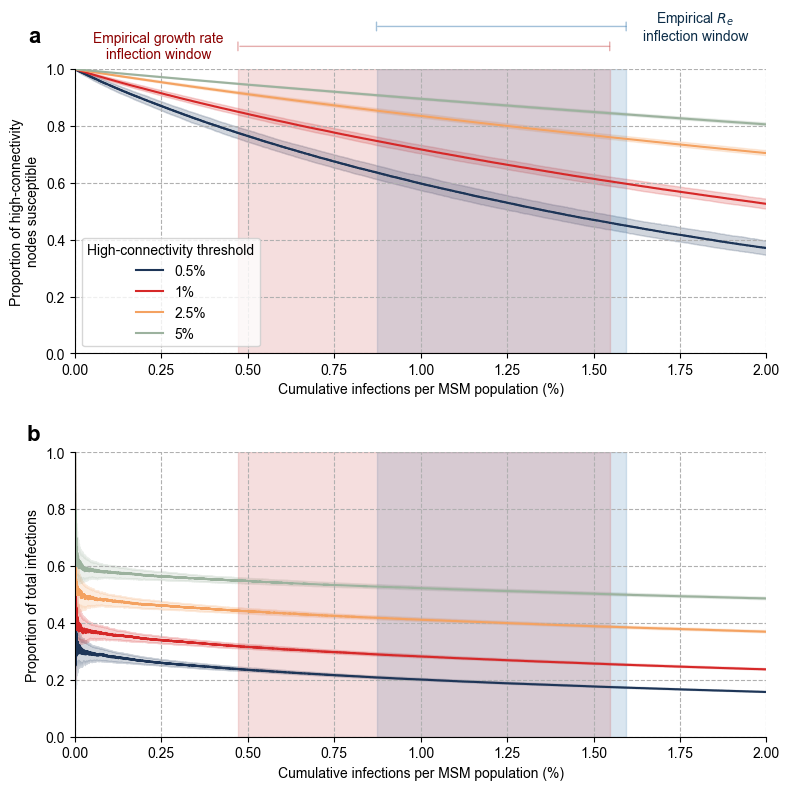

In [6]:
under_18_prop = 0.207; female_prop = 0.511
ny_county_prop = 0.138; ny_county_pop = 1596273	
kings_county_prop = 0.067; kings_county_pop = 2590516	
queens_county_prop = 0.053; queens_county_pop = 2278029	
bronx_county_prop = 0.048; bronx_county_pop = 1379946	
richmond_county_prop = 0.051; richmond_county_pop = 491133
msm_pop = (ny_county_pop*ny_county_prop + kings_county_pop*kings_county_prop + queens_county_pop*queens_county_prop + bronx_county_pop*bronx_county_prop + richmond_county_pop*richmond_county_prop) * (1 - under_18_prop) * (1 - female_prop)
msm_pop = round(msm_pop, -3)

# Results from the epi inference:
# Re case window: 1230–2248
# gr case window: 665-2181

detection_rate = 0.6

min_re_cases=1230/detection_rate
max_re_cases=2248/detection_rate
min_gr_cases=665/detection_rate
max_gr_cases=2181/detection_rate



cset = [cmap3[1], cmap3[0], cmap3[2], cmap3[3]]

# try with 235k
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
xlim = [0, 2]
plot_high_conn_perc_remaining_all(deg_235k_14d_top, ax=axes[0], xlim=xlim, color=cset)
epi_windows(axes[0], min_re_cases=min_re_cases, max_re_cases=max_re_cases, min_gr_cases=min_gr_cases, max_gr_cases=max_gr_cases, total_cases=msm_pop, xlim=xlim)

plot_high_conn_perc_of_cases_all(deg_235k_14d_top, [0.5, 1, 2.5, 5], colors=cset, ax=axes[1], xlim=xlim)
epi_windows(axes[1], include_labels=False, min_re_cases=min_re_cases, max_re_cases=max_re_cases, min_gr_cases=min_gr_cases, max_gr_cases=max_gr_cases, total_cases=msm_pop, xlim=xlim)

# add panel labels
axes[0].text(-0.05, 1.15, 'a', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[1].text(-0.05, 1.1, 'b', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# more space between subplots
plt.tight_layout(h_pad=2)

plt.show()